<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import warnings

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import spacy
import os
import eli5

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

from tqdm import tqdm
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from joblib import dump, load

In [3]:
data = "toxic_comments1"
data_grid = "grid"

In [4]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0])
else:
    print('Something is wrong')

In [5]:
random = 777

In [6]:
df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
df.duplicated().sum()

0

In [9]:
df.duplicated().sum()

0

In [10]:
df.shape

(159292, 2)

In [11]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

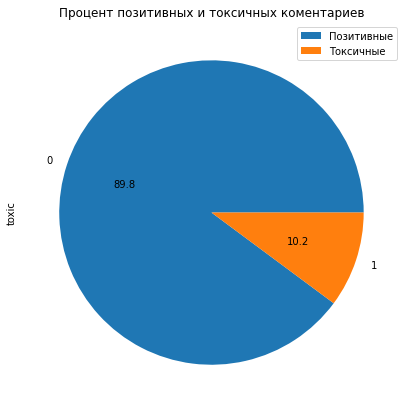

In [12]:
df['toxic'].value_counts().plot(kind='pie', autopct='%.1f', figsize=(7,7))
plt.legend(['Позитивные','Токсичные'])
plt.title('Процент позитивных и токсичных коментариев');

* Присутсвует сильный дизбаланс классов.
* В строках содержатся спец.символы

**Предобработка**

**Очистка**

Очистим тексты с помощию регулярных выражений:

* Приведем все к нижнему регистру
* Удалим спец символы \n \r
* Выберем только слова

In [13]:
def clean(text):
    text = text.lower()
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()

    return text

In [14]:
df['clean_text'] = df['text'].apply(clean)

In [15]:
df.sample(5)

,text,toxic,clean_text
43955,"I DID IMPROVE THE TOPIC, BY ASKING TO NOT BE S...",0,i did improve the topic by asking to not be sp...
121354,Half of 26 are what I hope seeing \n\nBetter s...,0,half of are what i hope seeing better solut...
12989,"""\n\nI don't know the poet articles you speak ...",0,i dont know the poet articles you speak of so ...
26826,"""But as to appease Floquenbeam - """"I believe t...",0,but as to appease floquenbeam i believe this ...
37386,"""The so-called Flag of Ireland should be remov...",0,the socalled flag of ireland should be removed...


**Лемантизация**

In [16]:
nlp = en_core_web_sm.load()

In [17]:
def lemmatize(text):
    temp = []
    for token in nlp(text):
        if token.is_stop == False:
            temp.append(token.lemma_)
    return " ".join(temp)

In [18]:
tqdm.pandas()
df['text_lemma'] = df['clean_text'].progress_apply(lemmatize)

In [19]:
dump(df,data)

In [16]:
df = load(data)

In [17]:
df.sample(5)

,text,toxic,clean_text,text_lemma
108493,Only being Russian guy.,0,only being russian guy,russian guy
151207,"""\n\nI am not very experienced in Wikipedia, b...",0,i am not very experienced in wikipedia but i f...,experienced wikipedia feel recent incident par...
101077,...and see next section. Let's continue this t...,0,and see next section lets continue this there,section let continue
103057,"Please do not remove or change images, especia...",0,please do not remove or change images especial...,remove change image especially intro box conse...
70173,"""\n\nSorry, no? """"No"""" is what a master says ...",1,sorry no no is what a master says to a dog n...,sorry master say dog parent say child cl...


In [18]:
df.isna().sum()

text          0
toxic         0
clean_text    0
text_lemma    0
dtype: int64

Разделим выборку

In [22]:
x = df.drop(columns=['toxic'])
y = df['toxic']

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=random)

In [24]:
x_valid, x_valid, y_valid, y_valid = train_test_split(x_train, y_train,
                                                                 shuffle=True,
                                                                 test_size=0.2,
                                                                 random_state=random)

In [25]:
print('Train:')
print(x_train.shape, y_train.shape)
print('Valid:')
print(x_valid.shape, y_valid.shape)
print('Test:')
print(x_test.shape, y_test.shape)

Train:
(127433, 3) (127433,)
Valid:
(25487, 3) (25487,)
Test:
(31859, 3) (31859,)


## Обучение

**Tf-idf и LogisticRegression**

1. Составим пайплайн: Tf-idf -> Classifier
2. В качестве Classifier попробуем LogisticRegression, так как остальные не отрабатывают за приемлемое время на таком количестве признаков

In [25]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=random, solver='liblinear'))
    ])

In [28]:
for col in ['clean_text', 'text_lemma']:
    pipe.fit(x_train[col], y_train);
    y_valid_pred = pipe.predict(x_valid[col])
    f1 = f1_score(y_valid, y_valid_pred)
    print('F1 for', col, 'is', f1)

Лемантизированный текст дает метрику лучше чем просто очищенный текс.

Посмотрим на самые важные слова

In [29]:
eli5.show_weights(pipe, top=50)

Попробуем улучшить результат.

In [30]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=random, solver='liblinear', max_iter=500)) #lbfgs
    ])

params = [
        {
            'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
            'model': [LogisticRegression(random_state=random, solver='liblinear')],
            'model__C': [1, 10, 50, 100, 200]
        }
]

In [31]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random)

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=cv, verbose=False)

In [32]:
%%time
grid.fit(x_train['text_lemma'], y_train)

In [33]:
dump(grid, data_grid);

In [37]:
grid = load(data_grid)
grid.best_params_, grid.best_score_

({'model': LogisticRegression(C=100, random_state=777, solver='liblinear'),
  'model__C': 100,
  'vectorizer__ngram_range': (1, 2)},
 0.7778460510408879)

In [35]:
grid.best_estimator_

**RandomForestClassifier**

In [19]:
stopwords = list(nltk_stopwords.words('english'))

In [20]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [26]:
x_train_vector = count_tf_idf.fit_transform(x_train['text_lemma'])
x_test_vector = count_tf_idf.transform(x_test['text_lemma'])

In [27]:
forest_model = RandomForestClassifier(random_state=random, class_weight='balanced')
forest_param = {'max_depth':[3, 7, 19],
                'n_estimators':[90, 145, 290],
                'max_features': [3, 5, 8]}

In [28]:
grid_forest = GridSearchCV(forest_model, param_grid=forest_param, scoring='f1', cv=4, n_jobs=-1)

In [29]:
grid_forest.fit(x_train_vector, y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=777),
             n_jobs=-1,
             param_grid={'max_depth': [3, 7, 19], 'max_features': [3, 5, 8],
                         'n_estimators': [90, 145, 290]},
             scoring='f1')

In [30]:
grid_forest.best_score_

0.2975889118130798

**DecisionTreeClassifier**

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
decision_model = DecisionTreeClassifier(random_state=random, class_weight='balanced')
decision_param = {'max_depth':[3, 7, 19]}

In [33]:
grid_decision = GridSearchCV(decision_model, param_grid=decision_param, scoring='f1', cv=4, n_jobs=-1)

In [34]:
%%time
grid_decision.fit(x_train_vector, y_train)

CPU times: user 2min 46s, sys: 95.8 ms, total: 2min 46s
Wall time: 2min 46s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=777),
             n_jobs=-1, param_grid={'max_depth': [3, 7, 19]}, scoring='f1')

In [35]:
grid_decision.best_score_

0.6320931226408381

## Выводы

In [38]:
test = grid.best_estimator_

test.fit(x_train['text_lemma'], y_train)

pred = test.predict(x_test['text_lemma'])

f1_score(y_test, pred)

0.7839727195225916

Модель, LogisticRegressionудовлетворяет требованиям заказчика.

В ходе тестирования это модель показала значение метрики f1 = 0.78397